In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Corner and traceplot of the model

* This is the default `A.S.A.P` model
* Three stages burn-in with 256 walkers using the "Snooker" moves, each stage has 250 steps.
* Using the walker position with the best likelihood as initial positions for the next stage. 
* Final sampling process has 400 steps.
* **SMF**: use the covariance matrix of SMFs
* **DeltaSigma** profiles: fit the radius between 0.15 to 15 Mpc.

In [3]:
test_dir = '../model/'
model_str = 'final_5'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results from the 3-stage burn-in results
burnin_file_1 = os.path.join(test_dir, 'asap_test_%s_burnin_1.npz' % model_str)
burnin_file_2 = os.path.join(test_dir, 'asap_test_%s_burnin_2.npz' % model_str)
burnin_file_3 = os.path.join(test_dir, 'asap_test_%s_burnin_2.npz' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load the burn-in results
(mod_burnin_samples_1, 
 mod_burnin_chains_1, 
 mod_burnin_lnprob_1, 
 mod_burnin_best_1, _, _) = io.load_npz_results(burnin_file_1)

(mod_burnin_samples_2, 
 mod_burnin_chains_2, 
 mod_burnin_lnprob_2, 
 mod_burnin_best_2, _, _) = io.load_npz_results(burnin_file_2)

(mod_burnin_samples_3, 
 mod_burnin_chains_3, 
 mod_burnin_lnprob_3, 
 mod_burnin_best_3, _, _) = io.load_npz_results(burnin_file_3)

mod_burnin_chains = np.concatenate([
    mod_burnin_chains_1, mod_burnin_chains_2, mod_burnin_chains_3], axis=1)

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

_, n_step, n_dim = mod_result_chains.shape

print(np.nanmax(mod_result_lnprob), mod_result_best)

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)
print(mod_result_best)

# Running model: asap_test_final_5
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with       walk moves for  4000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

### Corner plot

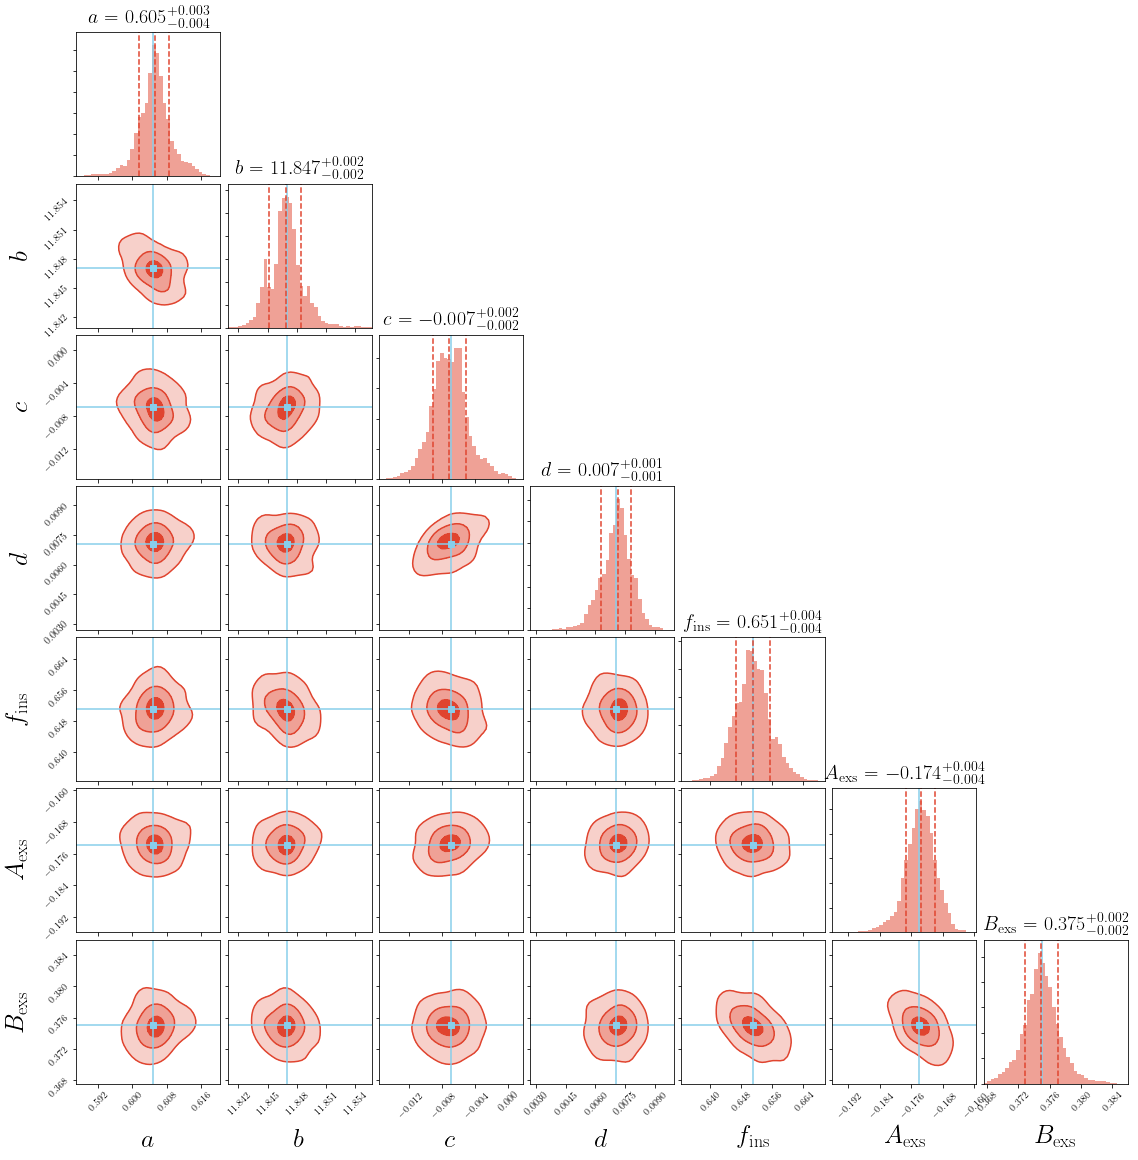

In [4]:
params_label = [r'$a$', r'$b$', r'$c$', r'$d$', 
                r'$f_{\rm ins}$', r'$A_{\rm exs}$', r'$B_{\rm exs}$']

params_range = [(0.585, 0.622), (11.831, 11.854), 
                (-0.024, 0.007), (-0.005, 0.0039), 
                (0.629, 0.679), 
                (-0.22, -0.162), (0.29, 0.41)]
title_fmt = '.3f'

mod_samples_use = mod_result_chains[:, 1000:, :].reshape([-1, n_dim])

mod_corner = plotting.plot_mcmc_corner(
    mod_samples_use, params_label, truths=mod_result_best, truth_color='skyblue',
    **{'title_fmt': title_fmt, 'ranges': params_range, 'plot_datapoints': False})

### Trace plot

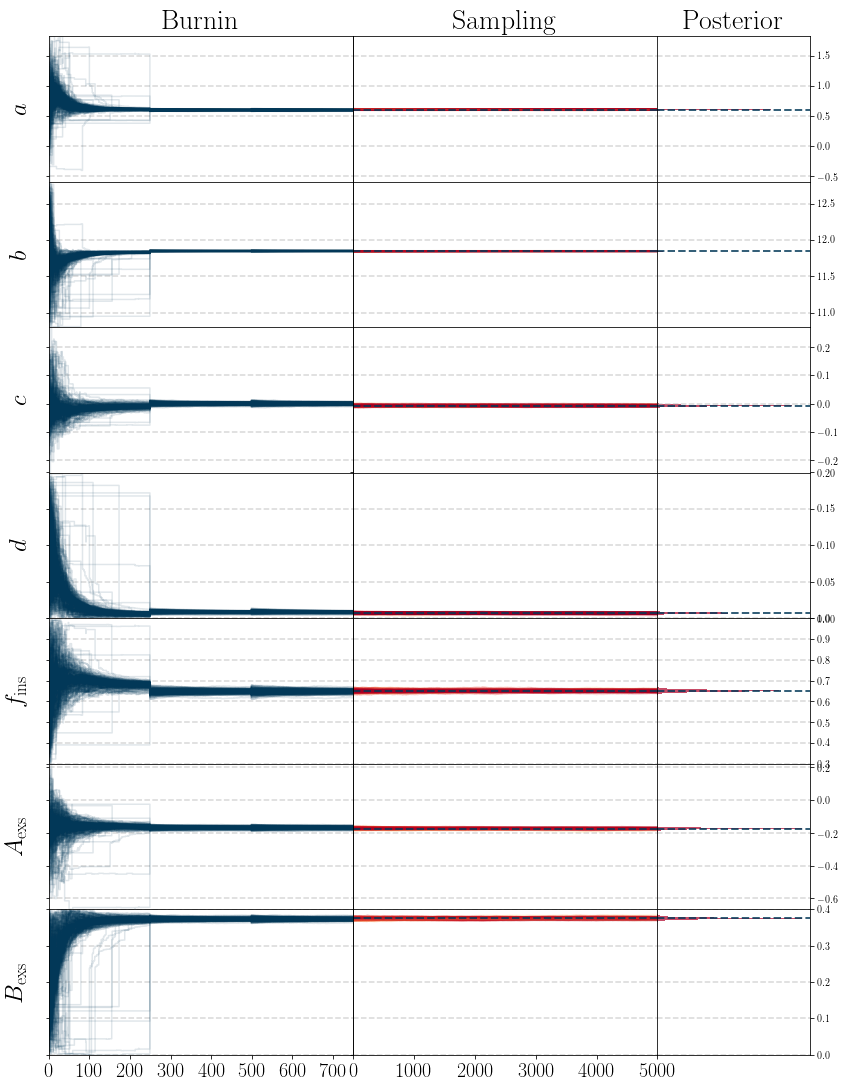

In [5]:
mod_trace = plotting.plot_mcmc_trace(
    mod_result_chains, params_label, 
    mcmc_best=mod_result_best, mcmc_burnin=mod_burnin_chains, 
    burnin_alpha=0.12, trace_alpha=0.15)

### Quick check of the SMFs

In [4]:
# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.6,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

# ln(Likelihood) for SMFs   : 205.3310
# ln(Likelihood) for DSigma : -343.3684


In [16]:
um_table = Table(um_data['um_mock'][mask_use])

um_table.add_column(Column(data=logms_inn, name='logms_inn_asap'))
um_table.add_column(Column(data=logms_tot, name='logms_tot_asap'))

#um_table.write('../data/asap_smdpl_mock_default.fits', overwrite=True)

/Users/song/Dropbox/work/project/asap/asap/smf.py:89: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for ii in np.arange(n_boots)).T
/Users/song/Dropbox/work/project/asap/asap/smf.py:147: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for ii in range(n_boots)


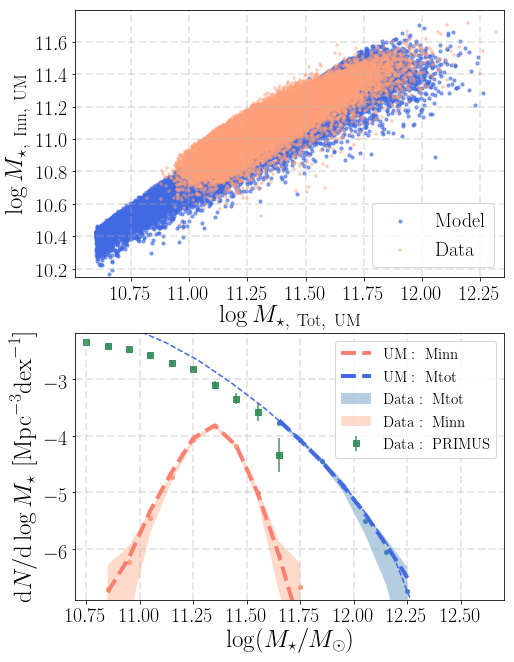

In [5]:
um_smf_tot_all = smf.get_smf_bootstrap(logms_tot, cfg['um']['volume'], 
                                       10, 10.9, 12.4, n_boots=1)

mod_smf_plot = plotting.plot_mtot_minn_smf(
    obs_data['smf_tot'], obs_data['smf_inn'], obs_data['mtot'], obs_data['minn'],
    um_smf_tot, um_smf_inn, logms_tot, logms_inn, obs_smf_full=obs_data['smf_full'],
    um_smf_tot_all=um_smf_tot_all, not_table=True)

### Save the figures

In [8]:
mod_corner.savefig('fig/fig3_corner_default.pdf', dpi=130)

mod_trace.savefig('fig/fig3_trace_default.png', dpi=120)

mod_smf_plot.savefig('fig/fig3_smf_default.png', dpi=120)